In [19]:
import numpy as np

import csv

In [72]:
import pandas as pd

df = pd.read_csv("../data/heart_attack_risk_dataset.csv")

#print(data.head(4)) #print first 4 entries
def get_string_entries(df):
    """
    df: pandas dataframe object
    Returns: list of values which contains str variables, makes sure all other values are floats or integers
    """
    keys_string = []
    mapping_list = {} #a dictionary which holds for the keys of keys_string a list which can be used to transform str values to numerical values
    for k in df.keys():
        if type(df[k][0]) == str:
            keys_string.append(k)
            mapping_list[k] =  list(set(df[k].tolist()))
        elif type(df[k][0]) == np.int64 or type(df[k][0]) == np.float64:
            pass
        else:
            raise ValueError('Dataframe pf contains entry which is not of type str, int, or float')
    return keys_string,mapping_list

def transform_to_numerical(df):
    """
    transform all string values in pf to numerical values
    df: pandas dataframe object
    Returns: pandas dataframe
    """
    string_keys,mapping_list = get_string_entries(df)
    for k in string_keys:
        df[k] = df[k].apply(lambda x: mapping_list[k].index(x))

    return df


#print(df.head(5))
dfN = transform_to_numerical(df)
print()


print(dfN.head(5))




   Age  Gender  Smoking  Alcohol_Consumption  Physical_Activity_Level    BMI  \
0   69       1        1                    0                        2  34.61   
1   32       0        0                    0                        2  22.75   
2   89       0        0                    1                        2  35.32   
3   78       0        0                    1                        2  18.23   
4   38       1        1                    0                        2  19.82   

   Diabetes  Hypertension  Cholesterol_Level  Resting_BP  Heart_Rate  \
0         1             0              152.1         171          85   
1         0             0              166.8         126         103   
2         0             0              272.3         123         127   
3         1             0              237.7         144         125   
4         0             0              207.7         123         107   

   Family_History  Stress_Level  Chest_Pain_Type  Thalassemia  \
0               0   

In [126]:
import torch
import torch.utils.data as data_utils

device = 'cpu'
train_ratio = 0.8 #how much of the data is used for training and how much for testing
batch_size=32

# Creating np arrays from dataframe
target = dfN['Heart_Attack_Risk'].values #save Heart_Attack_Risk as labels
features = dfN.drop('Heart_Attack_Risk', axis=1).values #remove the Heart_Attack_Risk because it is the label
#features = dfN.values #keeping the Heart_Attack_Risk should lead to 100% accuracy
features = (features-features.min(axis=0))/features.max(axis=0) #normalize to [0,1]


#creating torch tensors from np.arrays
target = torch.from_numpy(target).long().to(device)
features = torch.from_numpy(features).float().to(device)

index_train = int(features.shape[0]*train_ratio)

# Passing to DataLoader
train = data_utils.TensorDataset(features[:index_train], target[:index_train])
train_loader = data_utils.DataLoader(train, batch_size=batch_size,shuffle=True)

test = data_utils.TensorDataset(features[index_train:], target[index_train:])
test_loader = data_utils.DataLoader(train, batch_size=batch_size,shuffle=True)

In [127]:
from torch import nn

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self,neurons=64):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(19, neurons), #1st layer: pass the data of 19 points to 64 neurons
            nn.ReLU(),
            nn.Linear(neurons, neurons), #2. layer: 64 neurons to 64 neurons
            nn.ReLU(),
            nn.Linear(neurons, 3) #3. layer: 64 to 3 neurons
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

In [128]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1/3)

In [129]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct,test_loss

Epoch 1
-------------------------------
loss: 1.100213  [   32/40000]
loss: 0.984680  [ 3232/40000]
loss: 1.049841  [ 6432/40000]
loss: 1.031826  [ 9632/40000]
loss: 1.118828  [12832/40000]
loss: 1.024244  [16032/40000]
loss: 1.135497  [19232/40000]
loss: 1.050432  [22432/40000]
loss: 1.066187  [25632/40000]
loss: 1.031249  [28832/40000]
loss: 0.995099  [32032/40000]
loss: 1.101030  [35232/40000]
loss: 1.032397  [38432/40000]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.030375 

Epoch 2
-------------------------------
loss: 0.921533  [   32/40000]
loss: 1.029786  [ 3232/40000]
loss: 1.125267  [ 6432/40000]
loss: 1.014347  [ 9632/40000]
loss: 0.995187  [12832/40000]
loss: 1.031647  [16032/40000]
loss: 1.037320  [19232/40000]
loss: 0.987154  [22432/40000]
loss: 0.998252  [25632/40000]
loss: 1.140782  [28832/40000]
loss: 0.990072  [32032/40000]
loss: 1.071726  [35232/40000]
loss: 1.007137  [38432/40000]
Test Error: 
 Accuracy: 50.0%, Avg loss: 1.029883 

Epoch 3
----------------------------

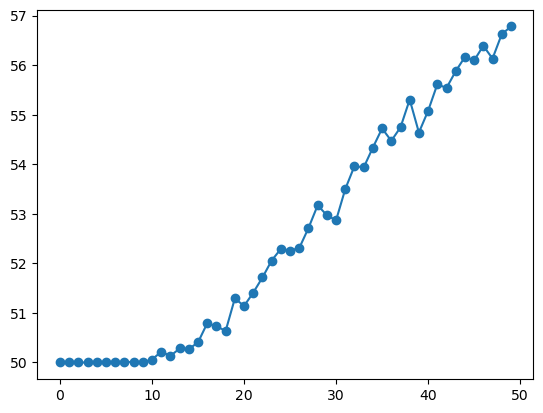

In [132]:
model = NeuralNetwork(neurons=100).to(device)
epochs = 50

#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

accs=[];losss=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    acc,loss = test(test_loader, model, loss_fn)
    accs.append(acc); losss.append(loss)
plt.plot(accs,'-o')

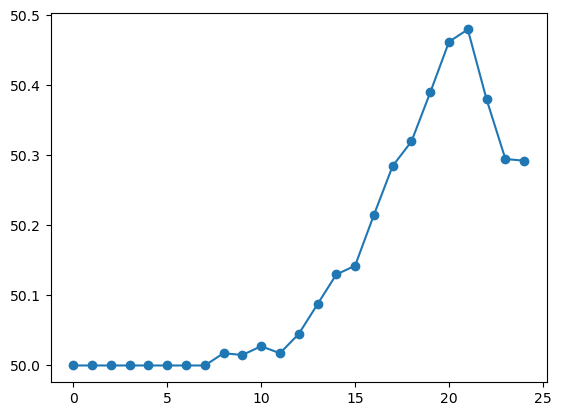

In [116]:
plt.plot(accs,'-o')

Parameter containing:
tensor([[ 2.8241e-01, -7.1794e-01,  4.1896e-01,  ...,  5.4405e-01,
         -6.1842e-01,  4.7558e-02],
        [-1.0268e-01, -7.1012e-04,  3.6187e-01,  ..., -3.9131e-01,
         -2.6537e-01,  1.6213e-03],
        [ 7.4236e-01, -6.4451e-01,  7.9619e-01,  ...,  6.8615e-01,
         -3.5445e-01,  1.0480e+00],
        ...,
        [-2.8617e-01,  2.3468e-01, -3.2720e-01,  ..., -1.4627e+00,
          3.0136e-01, -1.2903e-01],
        [ 7.4672e-01,  1.4655e-01,  2.6188e-01,  ...,  1.7932e-01,
         -3.1127e-01, -6.0670e-01],
        [ 1.0283e-01,  6.8443e-02, -1.6085e-01,  ..., -5.6357e-01,
          2.6022e-01,  5.0676e-02]], requires_grad=True)


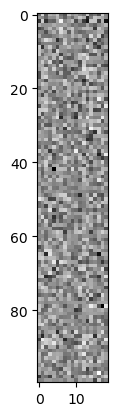

Parameter containing:
tensor([-0.0866, -0.4058, -1.0630, -0.1889,  0.1247, -0.1144, -0.3697,  0.0340,
        -0.5217, -0.4854,  0.1451, -0.1308,  0.4039, -0.1172, -0.1645,  0.1637,
        -0.1609, -0.3138, -0.3790, -0.2570,  0.1273, -0.2482, -0.0070,  0.2524,
         0.0591, -0.1865, -0.4196, -0.3560, -0.1196,  0.0775,  0.0284,  0.0894,
        -0.2491, -0.3085,  0.0033, -0.2680, -0.0920, -0.5267, -0.3294, -0.2400,
         0.2044, -0.3530, -0.2252, -0.0909,  0.2019, -0.0695, -0.3601, -0.3674,
        -0.0686, -0.4104, -0.2031, -0.0329, -0.2202, -0.2498, -0.3717, -0.2424,
        -0.4057,  0.2569, -0.5908, -0.0604,  0.0202, -0.2398, -0.1505, -0.0214,
        -0.1537, -0.4612,  0.2882, -0.4258,  0.0924, -0.0804,  0.1044, -0.4766,
         0.0286,  0.3576, -0.3002,  0.2586, -0.7774, -0.1815,  0.0601, -0.2219,
        -0.1368, -0.0833, -0.0559,  0.0128, -0.3016, -0.1973,  0.0613, -0.0463,
         0.2117, -0.0190,  0.1802, -0.1519,  0.0472,  0.2207,  0.1511,  0.0550,
         0.1595,  

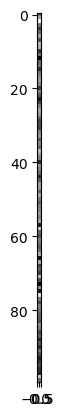

Parameter containing:
tensor([[ 0.0821,  0.0562, -0.0105,  ..., -0.0304,  0.0026, -0.0010],
        [-0.0049,  0.0386,  0.1809,  ...,  0.2309,  0.1071,  0.2614],
        [-0.1797,  0.3182, -0.6527,  ..., -0.3422,  0.2397, -0.2340],
        ...,
        [-0.2340, -0.1158, -0.1483,  ..., -0.2192, -0.0137,  0.1516],
        [ 0.1041, -0.1288, -0.2157,  ...,  0.0222, -0.0229,  0.1576],
        [-0.1741, -0.0251, -0.4434,  ..., -0.1368, -0.0218, -0.0670]],
       requires_grad=True)


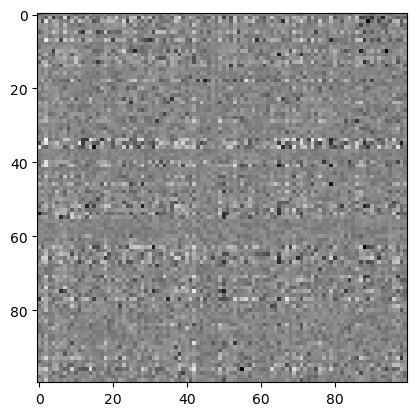

Parameter containing:
tensor([-0.2646, -0.6341, -0.3995, -0.4203, -0.1041, -0.3155, -0.2043, -0.5272,
        -0.2058, -0.1916, -0.9395, -0.6417, -0.4687, -0.4960, -0.5415, -0.1472,
        -0.2556, -0.1654, -0.4817, -0.1787, -0.5255, -0.1994, -0.2369, -0.3400,
        -0.3154, -0.3369, -0.4193, -0.3013, -0.3448, -0.2634, -0.1593, -0.1574,
        -0.3566, -0.2712,  0.0516, -0.4538, -0.6797, -0.1220, -0.1027, -0.1109,
        -0.6339, -0.5976, -0.1068, -0.2909, -0.2798, -0.1267, -0.7104, -0.2590,
        -0.6695, -0.4428, -0.3075, -0.4352, -0.5806, -0.6285, -0.4179, -0.2238,
        -0.1642, -0.3206, -0.1295, -0.2230, -0.2320, -0.3391, -0.2229, -0.5919,
        -0.3829, -0.8916, -0.8260, -0.8020, -0.4069, -0.3700, -0.1676, -0.2570,
        -0.2085, -0.4885, -0.4207, -0.8790, -0.2308, -0.4928, -0.3674, -0.6197,
        -0.4743, -0.2139, -0.2974, -0.2715, -0.5917, -0.1429, -0.4056, -0.2998,
        -0.0278, -0.8414, -0.1799, -0.2910, -0.0564, -0.0473, -0.2858, -0.3445,
        -0.2331, -

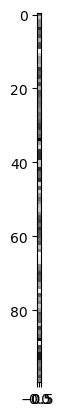

Parameter containing:
tensor([[ 4.4132e-02, -3.6330e-01, -3.6689e-01,  2.4198e-01,  8.5776e-02,
          3.8402e-01,  1.7273e-01, -2.0977e-01,  4.2300e-02,  4.0207e-02,
          2.9630e-01,  2.2841e-01, -1.0460e-01,  2.8121e-01, -4.7054e-02,
         -7.9420e-02, -7.9929e-02, -4.4050e-02, -4.3052e-01,  2.4769e-02,
          1.5974e-01,  4.5000e-03,  8.3798e-02,  2.2273e-01,  7.3402e-02,
          1.5940e-01,  1.6137e-01,  1.7332e-01, -1.3524e-01,  2.5053e-01,
         -3.9308e-02,  1.3750e-01, -1.9551e-01,  1.9822e-01,  1.7137e-01,
         -4.2244e-01,  2.2988e-01,  3.7686e-02,  3.2328e-02, -3.8482e-02,
          3.7823e-01,  5.1469e-01,  2.2098e-02, -1.3570e-01, -1.3489e-01,
         -1.5767e-02,  4.1450e-01, -7.4817e-02, -6.7207e-02,  5.0606e-02,
          5.7551e-02,  4.0686e-02,  1.8823e-01, -2.0474e-01, -2.0360e-01,
          8.6166e-02,  3.8544e-02,  8.0965e-02, -6.0533e-02,  1.8629e-03,
          3.0577e-01,  7.8166e-02,  7.2016e-02,  5.5402e-01,  2.9945e-01,
          3.3507

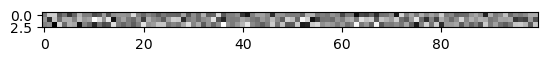

Parameter containing:
tensor([ 0.3646, -0.4953, -0.0674], requires_grad=True)


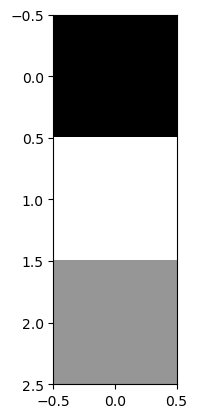

In [123]:
import matplotlib.pyplot as plt

for param in model.parameters():
    print(param)
    arr = param.data.detach().numpy()
    if len(arr.shape)==2:
        plt.imshow(arr,cmap='Greys')
        plt.show()
    else:
        plt.imshow(np.reshape(arr,(len(arr),1)),cmap='Greys')
        plt.show()
    

In [54]:
param.data

tensor([ 0.6015, -0.3205, -0.1659])